In [12]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import cProfile, pstats, io, string
import math

# Question 2 - Clustering

In [13]:
dt = pd.read_csv('Reviews.csv', sep=",", usecols = [i for i in range(1,10)])

In [14]:
dt.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
dt.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


## Clean up data

In [16]:
dt = dt.drop_duplicates(subset=["UserId","ProfileName","Time","Text"], keep='first', inplace=False)
dt = dt[dt["HelpfulnessNumerator"] <= dt["HelpfulnessDenominator"]] # remove the numerator greater than denominator

In [17]:
dt.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,393931.000000,393931.000000,393931.000000,3.939310e+05
mean,1.734393,2.204805,4.179397,1.296449e+09
std,6.872280,7.534791,1.311927,4.840344e+07
min,0.000000,0.000000,1.000000,9.393408e+08
25%,0.000000,0.000000,4.000000,1.271376e+09
50%,0.000000,1.000000,5.000000,1.311638e+09
75%,2.000000,2.000000,5.000000,1.332979e+09
max,866.000000,923.000000,5.000000,1.351210e+09


In [18]:
dt.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

There is a very few number of null values. Let's fill them:

In [19]:
dt['ProfileName'].fillna('', inplace=True)
dt['Summary'].fillna('', inplace=True)

In [20]:
dt.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Tokenize the text 

In [21]:
product_id = []
summary = []
reviews = []
new_df = pd.DataFrame()
for product, group in dt.groupby('ProductId'):
    product_id.append(product)
    reviews.append(" ".join(list(group['Text'])))
    summary.append(" ".join(list(map(str,group['Summary']))))
    
new_df['ProductId'] = product_id
new_df['reviews'] = reviews

In [22]:
def clean_text(text):
    stop_words = set(stopwords.words('english')) # obtain the stop words
    good_words = [] # save the correct words to consider like tokens
    tokenizer = RegexpTokenizer("[\w']+") # function to recognize the tokens
    words = tokenizer.tokenize(text) # tokenize the text 
    for word in words:
        # check if the word is lower and it isn't a stop word or a number
        if word.lower() not in stop_words and word.isalpha(): 
            word = PorterStemmer().stem(word) # use the stemmer function
            good_words.append(word.lower()) # insert the good token to lower case
        
    return good_words

In [23]:
%%time
# use the interest column..
new_df["reviews"] = [clean_text(x) for x in list(new_df["reviews"])]
new_df.head()

Wall time: 27min 37s


,ProductId,reviews
0,0006641040,"[day, person, say, chicken, soup, probabl, go,..."
1,141278509X,"[product, archer, farm, best, drink, mix, ever..."
2,2734888454,"[dog, love, chicken, product, china, wont, buy..."
3,2841233731,"[book, easi, read, ingredi, avail, store, unli..."
4,7800648702,"[came, huge, tin, much, bigger, expect, cooki,..."


In [24]:
%%time

tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, min_df = 0.01)
tfidf_matrix = tfidf.fit_transform(new_df["reviews"])

Wall time: 23.1 s


In [25]:
%%time
len(tfidf.vocabulary_)

Wall time: 0 ns


1740

In [26]:
%%time
dn = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)

Wall time: 3.68 s


In [27]:
dn

,0,1,2,3,4,5,6,7,8,9,...,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739
0,0.013209,0.006562,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010587,...,0.0,0.007034,0.0,0.010472,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.191621,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67619,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67620,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67621,0.000000,0.000000,0.328941,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
67622,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [28]:
svd = TruncatedSVD(n_components=350)
new_dn = svd.fit_transform(dn)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum()*100)

[0.01284971 0.02532599 0.01783335 0.01390644 0.01191672 0.01048781
 0.00890187 0.00793407 0.00694107 0.00641578 0.00598934 0.00566482
 0.0052877  0.00500848 0.00488534 0.00468479 0.00457318 0.00438951
 0.00430708 0.00413448 0.0040118  0.00400596 0.00390218 0.00386503
 0.00378525 0.0037135  0.00361557 0.00355142 0.00348168 0.00345191
 0.00333923 0.00323925 0.00320581 0.0031668  0.00310885 0.00302393
 0.00297262 0.00289839 0.00287718 0.00279555 0.00277909 0.0027433
 0.00268713 0.00267404 0.00263782 0.00262516 0.0026132  0.00256031
 0.0025226  0.0024905  0.00246318 0.00245834 0.00241211 0.00236393
 0.0023514  0.00230668 0.0022922  0.00225894 0.00222966 0.00221729
 0.00220726 0.00218499 0.00215403 0.00213931 0.0021202  0.00210534
 0.00208763 0.00207044 0.00204699 0.00202512 0.00199146 0.00198459
 0.00196502 0.00194595 0.00193024 0.00191565 0.00190434 0.00188603
 0.00187565 0.00187467 0.00185445 0.00184012 0.00181171 0.00180686
 0.00179391 0.00177584 0.00176105 0.00174447 0.0017351  0.00172

In [29]:
def profile(fnc):

    """a decorator that uses Cprofile to profile a function"""

    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc (*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

## K-Means 1


In [30]:
from collections import defaultdict


def calc_distance(X1, X2):
    return np.sqrt(sum((X1 - X2)**2))


def initialization(dn, k):
    temp = random.sample(list(dn), k)
    return np.array(temp)


def assign_cluster(new_dn, centroids):
    print('assign_cluster')
    clusters = defaultdict(list)
    clusters_idx = defaultdict(list)
    for i, x in enumerate(new_dn):
        centroid = np.argmin([np.array([np.linalg.norm(x-mu_j) for j,mu_j in enumerate(centroids)])])
        clusters[centroid].append(x)
        clusters_idx[centroid].append(i)
    return clusters, clusters_idx


@profile
def kmeans(new_dn, k, centroids = None, cluster_prec = defaultdict(list),init=True):
    if init:
        centroids = initialization(new_dn, k)

    clusters, clusters_idx = assign_cluster(new_dn, centroids)
    if clusters_idx == cluster_prec[1]:
        print('stop condition')
        return clusters
    else:
        centroids = update_centroid(centroids, clusters, k)
        return kmeans(new_dn, k, centroids, cluster_prec = (clusters.copy(), clusters_idx),init=False)

def update_centroid(centroids,clusters,k):
    upd_c = np.array([np.round(np.mean(clusters[i], axis = 0),5) if i in clusters.keys() else centroids[i] for i in range(k)])
    return upd_c

## K Means 2

In [31]:
class Kmeans():

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.prev_labels = [1]
        self.labels = []


    def initialize_algo(self, matrix):
        random_indices = np.random.choice(len(matrix), size= self.n_clusters, replace=False)
        self.centroids = matrix[random_indices, :]



    def stop_iteration_flag(self):
        if self.labels == self.prev_labels:
            return True
        else:
            return False

    
    def compute_distance(self, vec1, vec2):
        return np.linalg.norm(vec1 - vec2)

    
    def assign_clusters(self, matrix):
        self.clusters = {}
        self.prev_labels = self.labels.copy()
        self.labels = []
        
        for row in matrix:
            centroid_idx = np.argmin([self.compute_distance(row, centroid) for centroid in self.centroids])
            self.clusters.setdefault(centroid_idx, []).append(row)
            self.labels.append(centroid_idx)

    
    def update_centroids(self):
        self.centroids = [np.mean(i, axis = 0) for i in self.clusters.values()]

    @profile
    def fit(self, matrix):
        self.initialize_algo(matrix)
        iter_count = 0
        while not self.stop_iteration_flag():
            print("iteration no. {0}".format(iter_count))
            self.assign_clusters(matrix)
            self.update_centroids()
            iter_count += 1
        
        return self.labels

## Test K Means

In [32]:
model_test = Kmeans(5)
ans = model_test.fit(new_dn)

iteration no. 0
iteration no. 1
iteration no. 2
iteration no. 3
iteration no. 4
iteration no. 5
iteration no. 6
iteration no. 7
iteration no. 8
iteration no. 9
iteration no. 10
iteration no. 11
iteration no. 12
iteration no. 13
iteration no. 14
iteration no. 15
iteration no. 16
iteration no. 17
iteration no. 18
iteration no. 19
iteration no. 20
iteration no. 21
iteration no. 22
iteration no. 23
iteration no. 24
iteration no. 25
iteration no. 26
iteration no. 27
iteration no. 28
iteration no. 29
iteration no. 30
iteration no. 31
iteration no. 32
         189688866 function calls (178530906 primitive calls) in 652.542 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001  652.542  652.542 <ipython-input-31-cb6e4f099559>:40(fit)
       33   31.323    0.949  634.488   19.227 <ipython-input-31-cb6e4f099559>:26(assign_clusters)
  2231592   20.788    0.000  509.708    0.000 <ipython-input-31-cb6e4f099559>:3

In [62]:
hansel = {}
for idx, key in enumerate(ans):
    hansel.setdefault(key, set()).add(idx)

In [42]:
%%time
c = kmeans(new_dn, 5)

assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
assign_cluster
stop condition
         5409993 function calls (5071873 primitive calls) in 4.429 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    4.429    4.429 <ipython-input-30-480554d80654>:24(kmeans)
        1    0.259    0.259    4.427    4.427 <ipython-input-30-480554d80654>:13(assign_cluster)
    67624    0.759    0.000    3.466    0.000 <ipython-input-30-480554d80654>:18(<listcomp>)
743864/405744    0.631    0.000    3.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   338120    0

         5410088 function calls (5071963 primitive calls) in 56.129 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   56.129   56.129 <ipython-input-30-480554d80654>:24(kmeans)
        1    0.000    0.000   51.515   51.515 <ipython-input-29-cf09af59c379>:5(inner)
        1   51.515   51.515   51.515   51.515 {method 'enable' of '_lsprof.Profiler' objects}
        1    0.257    0.257    4.410    4.410 <ipython-input-30-480554d80654>:13(assign_cluster)
    67624    0.762    0.000    3.447    0.000 <ipython-input-30-480554d80654>:18(<listcomp>)
743879/405754    0.629    0.000    3.190    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   338120    0.184    0.000    2.685    0.000 <__array_function__ internals>:2(norm)
   338120    1.124    0.000    2.267    0.000 D:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:2316(norm)
   338120    0.176    0.000    0.626    0.

         5410088 function calls (5071963 primitive calls) in 110.231 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  110.231  110.231 <ipython-input-30-480554d80654>:24(kmeans)
        1    0.000    0.000  105.310  105.310 <ipython-input-29-cf09af59c379>:5(inner)
        1  105.310  105.310  105.310  105.310 {method 'enable' of '_lsprof.Profiler' objects}
        1    0.272    0.272    4.662    4.662 <ipython-input-30-480554d80654>:13(assign_cluster)
    67624    0.822    0.000    3.650    0.000 <ipython-input-30-480554d80654>:18(<listcomp>)
743879/405754    0.665    0.000    3.392    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   338120    0.199    0.000    2.828    0.000 <__array_function__ internals>:2(norm)
   338120    1.185    0.000    2.380    0.000 D:\Anaconda\lib\site-packages\numpy\linalg\linalg.py:2316(norm)
   338120    0.183    0.000    0.659    0

# KMeans++

In [47]:
model = KMeans(init = 'k-means++', n_clusters = 5)

In [48]:
slice = new_dn[:] # only column 3 to 6

In [49]:
model.fit(slice)

KMeans(n_clusters=5)

In [50]:
cluster = model.predict(slice)

In [58]:
gretel = {}
for idx, key in enumerate(list(cluster)):
    gretel.setdefault(key, set()).add(idx)

In [119]:
witch = {} #keys gretel , values hansel
for candy in gretel.keys():
    witch[candy] = [len(hansel[ginger].intersection(gretel[candy])) for ginger in hansel.keys()]

In [120]:
witch

{2: [36595, 7, 157, 1, 2069],
 0: [3, 4945, 0, 0, 2],
 1: [118, 3, 14333, 0, 806],
 4: [2, 0, 1, 4597, 0],
 3: [2530, 0, 1444, 2, 9]}

### 3.1 Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

### 3.2 Provide the number of product in each cluster

In [128]:
get_idx, counts_per_cluster = np.unique(ans, return_counts=True)
print("Show the number of products per each cluster: \n")
for idx, val in enumerate(counts_per_cluster):
    print("The cluster {} has {} products".format(idx, val))

Show the number of products per each cluster: 

The cluster 0 has 39248 products
The cluster 1 has 4955 products
The cluster 2 has 15935 products
The cluster 3 has 4600 products
The cluster 4 has 2886 products


### 3.3 Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!

In [151]:
new_df["cluster"] = ans
gabibbo = pd.merge(new_df[["ProductId","cluster"]], dt[["ProductId","Score"]], on="ProductId")
gabibbo

,ProductId,cluster,Score
0,0006641040,0,4
1,0006641040,0,5
2,0006641040,0,3
3,0006641040,0,5
4,0006641040,0,1
...,...,...,...
393926,B009SF0TN6,4,5
393927,B009SR4OQ2,0,5
393928,B009UOFU20,2,1
393929,B009WSNWC4,0,5


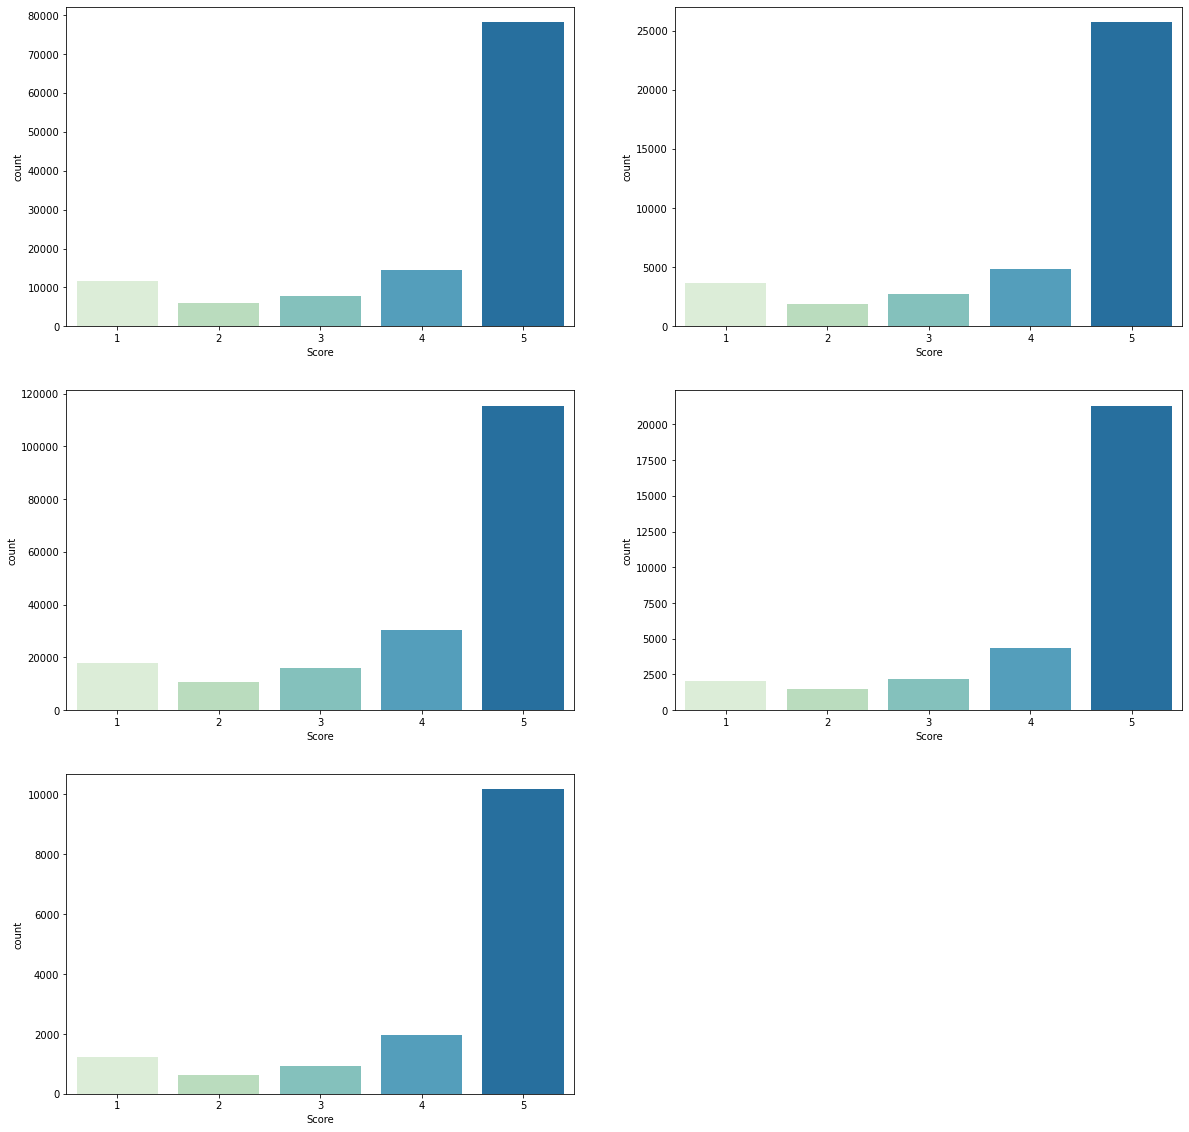

In [257]:
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.barplot(x = "Score", y = "count", data = gabibbo[gabibbo.cluster == 0].groupby([gabibbo.Score]).Score.count().to_frame('count').reset_index(), ax = axes[0, 0], palette = "GnBu")
sns.barplot(x = "Score", y = "count", data = gabibbo[gabibbo.cluster == 1].groupby([gabibbo.Score]).Score.count().to_frame('count').reset_index(), ax = axes[0, 1], palette = "GnBu")
sns.barplot(x = "Score", y = "count", data = gabibbo[gabibbo.cluster == 2].groupby([gabibbo.Score]).Score.count().to_frame('count').reset_index(), ax = axes[1, 0], palette = "GnBu")
sns.barplot(x = "Score", y = "count", data = gabibbo[gabibbo.cluster == 3].groupby([gabibbo.Score]).Score.count().to_frame('count').reset_index(), ax = axes[1, 1], palette = "GnBu")
sns.barplot(x = "Score", y = "count", data = gabibbo[gabibbo.cluster == 4].groupby([gabibbo.Score]).Score.count().to_frame('count').reset_index(), ax = axes[2, 0], palette = "GnBu")

fig.delaxes(axes[2,1])

### 3.4 Get the number of unique users writing reviews in each cluster

In [ ]:
gabibbo.loc[gabibbo.cluster == k].groupby([gabibbo.Score]).Score.count()

In [52]:
new_dataframe = pd.DataFrame()
new_dataframe['ProductId'] = new_df['ProductId']
new_dataframe['Cluster'] = cluster

In [53]:
dt.loc[(dt['ProductId'] == 'B009UOFU20') | (dt['ProductId'] == 'B009UOFTUI')]

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1477,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,1,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."


In [54]:
new_dataframe.groupby('Cluster').count().sort_values(by='ProductId')
lista = new_dataframe.loc[new_dataframe['Cluster'] == 52]
lista2 = lista['ProductId']
new_df.loc[new_df['ProductId'].isin(lista2)]

,ProductId,reviews


In [55]:
slice['cluster'] = cluster

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Let's plot the results

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
fig = plt.figure()
for cluster in range(0, 10):
    plt.scatter(slice[slice.cluster == cluster].Score, slice[slice.cluster == cluster].HelpfulnessNumerator)
plt.show()

In [ ]:
model = KMeans(verbose=False)
slice = dataset.iloc[:,3:6]
model.fit(slice)
cluster_values = model.predict(slice)
dataset['cluster'] = cluster_values
fig = plt.figure()
for cluster in range(0,10):
    plt.scatter(dataset[dataset.cluster == cluster].Score, dataset[dataset.cluster == cluster].HelpfulnessDenominator)
plt.show()

In [ ]:
fig = plt.figure()
for cluster in range(0,10):
    plt.scatter(dataset[dataset.cluster == cluster].HelpfulnessNumerator, dataset[dataset.cluster == cluster].HelpfulnessDenominator)
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
slice = dataset.iloc[:,3:6]

In [ ]:
elbow = {}
for k in tqdm(range(3,20)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(slice)
    elbow[k] = elbow_model.inertia_ 

In [ ]:
plt.plot(list(elbow.keys()), list(elbow.values()))

In [ ]:
products_per_cluster = {}
for cluster in range(0,6):
    products_per_cluster[cluster] = len(dataset[dataset.cluster == cluster].ProductId.unique())

In [ ]:
products_per_cluster

In [ ]:
users_per_cluster = {}
for cluster in range(0,6):
    users_per_cluster[cluster] = len(dataset[dataset.cluster == cluster].UserId.unique())

In [ ]:
users_per_cluster

In [ ]:
row_per_cluster = {}
for cluster in range(0,6):
    row_per_cluster[cluster] = len(dataset[dataset.cluster == cluster])

In [ ]:
row_per_cluster